In [1]:
import numpy as np
import pandas as pd
import warnings
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def read_data(data_path, filename):
    return pd.read_csv(os.path.join(data_path,filename))

def get_standard_time(date):
    sec_per_hour = 3600
    anchor_time_stamp = 1585297516
    days_shift = (27-date)*24*sec_per_hour
    const_shift = 16*3600 + 25*60 + 16
    return anchor_time_stamp - days_shift - const_shift

def normalize_time(data, date):
    begin_time = get_standard_time(date)
    norm_minu_data = (order_data[['assigned_time','confirm_time','estimate_pick_time','promise_deliver_time']] - begin_time)/60
    norm_minu_data.loc[(norm_minu_data[['assigned_time','confirm_time','estimate_pick_time','promise_deliver_time']] < 0).any(axis=1)] = 0
    data.update(norm_minu_data)

def normalize_time_hour(data, date):
    begin_time = get_standard_time(date)
    norm_minu_data = (order_data[['assigned_time','confirm_time','estimate_pick_time','promise_deliver_time']] - begin_time)/3600
    norm_minu_data.loc[(norm_minu_data[['assigned_time','confirm_time','estimate_pick_time','promise_deliver_time']] < 0).any(axis=1)] = 0
    data.update(norm_minu_data)

def time_narrowing_data(data, start, range):
    data.loc[:,'estimate_pick_time'] -= start
    data.loc[:,'promise_deliver_time'] -= start
    narrowed_data = data[(data['estimate_pick_time'] > 0) & (data['estimate_pick_time'] < range)].copy(deep = True)
    return narrowed_data

def zoning_from_data(data, lng1, lng2, lat1, lat2):
    data = data.drop(columns= ['tracking_id', 'weather_grade', 'create_time', 'confirm_time', 'assigned_time', 'aoi_id'],errors='ignore')
    zoned_data = data[(lng1 <= data['pick_lng']) &
                      (lng2 >= data['pick_lng']) &
                      (lat1 <= data['pick_lat']) &
                      (lat2 >= data['pick_lat'])].copy(deep = True)
    return zoned_data

def sample_from_data(data, case_num, courier_num):
    cases = []; iloc1 = 0; iloc2 = 0
    for i in range(case_num):
        ccount = 1
        curname = data.iloc[iloc1]['courier_id']
        while ccount <= courier_num: #find the the right indexes to select
            iloc2 += 1
            if  data.iloc[iloc2]['courier_id'] != curname:
                curname = data.iloc[iloc2]['courier_id']
                ccount += 1
        cases.append(data.iloc[iloc1:iloc2].copy(deep = True))
        iloc1 = iloc2
    return cases


In [2]:
def generate_nodes_data(data, base_num):
    nodes_data = data[['pick_lng','pick_lat','deliver_lng','deliver_lat','promise_deliver_time','estimate_pick_time','shop_id']].copy()
    nodes_data.loc[:,'order_id'] = range(0,len(data))

    # ----- rstr_data ------
    rstr_data = nodes_data[['pick_lng','pick_lat','order_id','estimate_pick_time','shop_id']].rename(columns={'pick_lng':'longitude','pick_lat':'latitude','estimate_pick_time':'time'})
    rstr_data['type'] = 101
    # pick n drone-base
    order_per_shop = data.groupby(['shop_id']).count()
    drone_base_list = order_per_shop.sort_values(by=['wave_index'],ascending = False)[0:base_num].index.tolist()
    rstr_data.loc[rstr_data['shop_id'].isin(drone_base_list),'type'] = 103
    rstr_data.drop(columns=['shop_id'], inplace=True)

    # ----- cstm_data ------
    cstm_data = nodes_data[['deliver_lng','deliver_lat','order_id','promise_deliver_time']].rename(columns={'deliver_lng':'longitude','deliver_lat':'latitude','promise_deliver_time':'time'})
    cstm_data['type'] = 201

    # ----- concat_data -----
    nodes_data = pd.concat([rstr_data,cstm_data])
    nodes_data.reset_index(drop=True, inplace=True)
    return nodes_data

import math
def ground_distance(lng1, lat1, lng2, lat2):
    COEFFICIENT = 1.4
    RADIUS = 6367000.0
    # 经度差值
    deltaLng = lng2 - lng1
    # 纬度差值
    deltaLat = lat2 - lat1
    # 平均纬度
    b = (lat1 + lat2) / 2.0
    # 东西距离
    x = math.radians(deltaLng) * RADIUS * math.cos(math.radians(b))
    # 南北距离
    y = RADIUS * math.radians(deltaLat)
    # 用平面的矩形对角距离公式计算总距离
    return math.sqrt(x * x + y * y)*COEFFICIENT

def drone_distance(lng1, lat1, lng2, lat2):
    RADIUS = 6367000.0
    deltaLng = lng2 - lng1
    deltaLat = lat2 - lat1
    b = (lat1 + lat2) / 2.0
    x = math.radians(deltaLng) * RADIUS * math.cos(math.radians(b))
    y = RADIUS * math.radians(deltaLat)
    return math.sqrt(x * x + y * y)

def cal_vehicle_matrix(nodes, vehicle_speed, vehicle_type='truck'):
    #Notice: Here Should plugin exNODES instead of NODES
    M = 1000
    n = nodes.shape[0] #the number of nodes
    lenthMatrix = np.zeros([n,n])
    if vehicle_type == 'drone':
        get_distance_matrix = drone_distance
        operate_time = 1
    else:
        get_distance_matrix = ground_distance
        operate_time = 1
    for i in range(n):
        for j in range(n):
            lenthMatrix[i,j] = get_distance_matrix(nodes['longitude'][i], nodes['longitude'][i], nodes['longitude'][j], nodes['longitude'][j])/vehicle_speed + operate_time
            # lenthMatrix[i,j] = get_distance_matrix(nodes['longitude'][i], nodes['longitude'][i], nodes['longitude'][j], nodes['longitude'][j])
        if vehicle_type == 'drone':
            lenthMatrix[i,i] = 0
        else:
            lenthMatrix[i,i] = M
    return lenthMatrix

def prepare_output_dir(path):
    if os.path.exists(path):
        return
    os.mkdir(path)
    print("created dir: " + path)

处理切分数据

In [ ]:
'''Major'''
sec_num = 50
base_num = 5  #default: 5
speed_rate = 2 #default: 1.5 (15)
order_data_path = '.\eleme_round1_testB\order'; filename = 'order_20200301.txt'; date = 1
output_dir = '.\eleme' + '_b' + str(base_num) + '_s' + str(int(speed_rate*10))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
order_data = read_data(order_data_path,filename)
normalize_time(order_data, 1)
# divide a group of cases in a specific area by specify longitude and latitude.
# llgt_range = [(121.4, 121.5, 39.2, 39.3),(121.5, 121.6, 39.2, 39.3),(121.4, 121.5, 39.1, 39.2),(121.4, 121.6, 39.1, 39.2),(121.4, 121.5, 39.0, 39.1),(121.5, 121.6, 39.0, 39.1)]
llgt_range = [(121.4, 121.5, 39.2, 39.3),(121.5, 121.6, 39.2, 39.3),(121.4, 121.5, 39.1, 39.2),(121.5, 121.6, 39.1, 39.2),(121.4, 121.5, 39.0, 39.1),(121.5, 121.6, 39.0, 39.1)]
# llgt_range = [(121.4, 121.5, 39.2, 39.3),(121.5, 121.6, 39.2, 39.3),(121.5, 121.6, 39.0, 39.1)]
for rg, llgt in enumerate(llgt_range):
    zoned_data = zoning_from_data(order_data,*llgt)
    order_num = len(zoned_data)
    for sec_i in range(order_num//sec_num):
        # 按顺序划分（可能会有问题，可以改成随机抽样）
        data_sec = zoned_data[sec_num*sec_i:sec_num*(sec_i+1)]
        nodes_data = generate_nodes_data(data_sec,base_num)
        order = ['longitude','latitude','type','order_id','time']
        nodes_data = nodes_data[order]
        ground_distance_matrix = cal_vehicle_matrix(nodes_data,200)
        drone_distance_matrix = cal_vehicle_matrix(nodes_data,200*speed_rate,'drone')
        # Output
        sec_name = filename.replace('.txt', '').replace('order_2020', '') + '_rg_' + str(rg) + '_sec_' + str(sec_i) + '\\'
        output_path = output_dir + '\\' + sec_name
        prepare_output_dir(output_path)
        nodes_data.to_csv(output_path  + 'exNodes.csv',index=False,header=False)
        pd.DataFrame(drone_distance_matrix).to_csv(output_path + 'Td.csv',index=False,header=False)
        pd.DataFrame(ground_distance_matrix).to_csv(output_path + 'Tt.csv',index=False,header=False)

In [4]:
'''Lunch & after'''
sec_num = 40 #30
base_num = 5  #default: 6
speed_rate = 1.5 #default: 1.5 (15)
order_data_path = '.\eleme_round1_testB\order'; filename = 'order_20200301.txt'; date = 1
# order_data_path = '.\eleme_round1_testB\order'; filename = 'order_20200302.txt'; date = 2

order_data = read_data(order_data_path,filename)
normalize_time(order_data, date)
lunch_timezone = (12,13) #（12,14)
lunch_order = order_data[(order_data["estimate_pick_time"]>=lunch_timezone[0]*60) & (order_data["estimate_pick_time"]<=lunch_timezone[1]*60)].copy()
afternoon_timezone = (14,18)
afternoon_order = order_data[(order_data["estimate_pick_time"]>=afternoon_timezone[0]*60) & (order_data["estimate_pick_time"]<=afternoon_timezone[1]*60)].copy()
llgt_range = [(121.4, 121.5, 39.2, 39.3),(121.5, 121.6, 39.2, 39.3),(121.4, 121.5, 39.1, 39.2),(121.5, 121.6, 39.1, 39.2),(121.4, 121.5, 39.0, 39.1),(121.5, 121.6, 39.0, 39.1)]


# lunch
output_dir = '.\eleme_lunch_test' #default: '.\eleme_lunch'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
order_data = lunch_order
for rg, llgt in enumerate(llgt_range):
    zoned_data = zoning_from_data(order_data,*llgt)
    order_num = len(zoned_data)
    for sec_i in range(order_num//sec_num):
        # 按顺序划分（可能会有问题，可以改成随机抽样）
        data_sec = zoned_data[sec_num*sec_i:sec_num*(sec_i+1)]
        nodes_data = generate_nodes_data(data_sec,base_num)
        order = ['longitude','latitude','type','order_id','time']
        nodes_data = nodes_data[order]
        nodes_data['time'] = nodes_data['time'] - nodes_data['time'].min()
        ground_distance_matrix = cal_vehicle_matrix(nodes_data,200)
        drone_distance_matrix = cal_vehicle_matrix(nodes_data,200*speed_rate,'drone')
        # Output
        sec_name = filename.replace('.txt', '').replace('order_2020', '') + '_rg_' + str(rg) + '_sec_' + str(sec_i) + '\\'
        output_path = output_dir + '\\' + sec_name
        prepare_output_dir(output_path)
        nodes_data.to_csv(output_path  + 'exNodes.csv',index=False,header=False)
        pd.DataFrame(drone_distance_matrix).to_csv(output_path + 'Td.csv',index=False,header=False)
        pd.DataFrame(ground_distance_matrix).to_csv(output_path + 'Tt.csv',index=False,header=False)

# # afternoon
# output_dir = '.\eleme_afternoon'
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)
# order_data = afternoon_order
# for rg, llgt in enumerate(llgt_range):
#     zoned_data = zoning_from_data(order_data,*llgt)
#     order_num = len(zoned_data)
#     for sec_i in range(order_num//sec_num):
#         # 按顺序划分（可能会有问题，可以改成随机抽样）
#         data_sec = zoned_data[sec_num*sec_i:sec_num*(sec_i+1)]
#         nodes_data = generate_nodes_data(data_sec,base_num)
#         order = ['longitude','latitude','type','order_id','time']
#         nodes_data = nodes_data[order]
#         ground_distance_matrix = cal_vehicle_matrix(nodes_data,200)
#         drone_distance_matrix = cal_vehicle_matrix(nodes_data,200*speed_rate,'drone')
#         # Output
#         sec_name = filename.replace('.txt', '').replace('order_2020', '') + '_rg_' + str(rg) + '_sec_' + str(sec_i) + '\\'
#         output_path = output_dir + '\\' + sec_name
#         prepare_output_dir(output_path)
#         nodes_data.to_csv(output_path  + 'exNodes.csv',index=False,header=False)
#         pd.DataFrame(drone_distance_matrix).to_csv(output_path + 'Td.csv',index=False,header=False)
#         pd.DataFrame(ground_distance_matrix).to_csv(output_path + 'Tt.csv',index=False,header=False)


created dir: .\eleme_lunch_test\0301_rg_3_sec_0\
created dir: .\eleme_lunch_test\0301_rg_3_sec_1\


3712


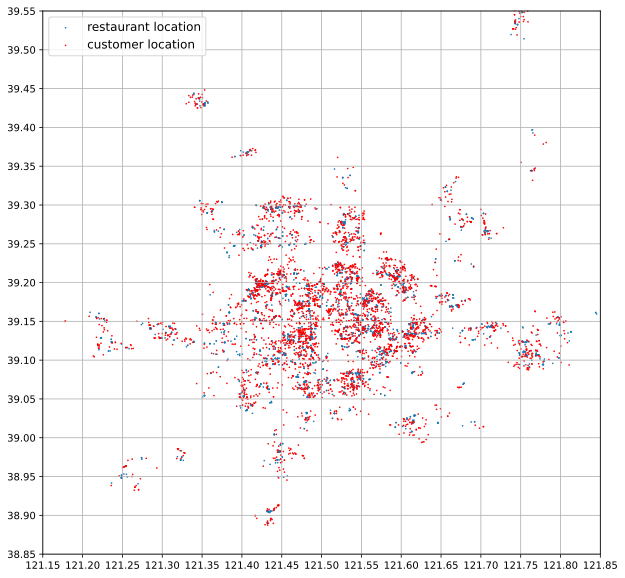

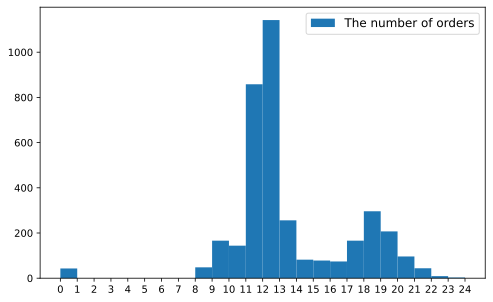

In [56]:
order_data_path = '.\eleme_round1_testB\order'; filename = 'order_20200302.txt'; date = 2
order_data = read_data(order_data_path,filename)

print(len(order_data))



data = order_data.copy()
''' scatter '''
plt.figure(figsize=(10,10))
plt.xticks(np.arange(121.1, 122.1 ,0.05))
plt.yticks(np.arange(38.8,39.7,0.05))
plt.xlim(121.15, 121.85)
plt.ylim(38.85, 39.55)
plt.scatter(data['pick_lng'],data['pick_lat'],s=0.5,label = 'restaurant location')
plt.scatter(data['deliver_lng'],data['deliver_lat'],s=0.5, c='r', label = 'customer location')
plt.legend(fontsize=12)
plt.grid()


''' hist '''
normalize_time_hour(data, 2)
plt.figure(figsize=(8,5))
bins = np.linspace(0,24,25)
plt.xticks(bins); #plt.xlim(0,24)
plt.hist(data['promise_deliver_time'],bins = bins,label='The number of orders')
plt.legend(fontsize=12)

In [44]:
order_data

,courier_id,wave_index,tracking_id,weather_grade,pick_lng,pick_lat,deliver_lng,deliver_lat,create_time,confirm_time,assigned_time,promise_deliver_time,estimate_pick_time,aoi_id,shop_id
1997,112996714,0,2100076057655215873,正常天气,121.377177,39.146558,121.383044,39.136461,1583043807,872.783333,1972.333333,2010.0,897.783333,276d7420a4c67c5ad5eed4b61082209b,c65e40bc29e060adf907308552e0ef27
2264,116737865,0,2100076070234096754,正常天气,121.574343,39.056566,121.579544,39.064491,1583053244,1020.750000,1981.900000,2025.0,1045.750000,452783b957adc3bddc7185b413bf85b6,24fd54cf8617b6be1f5ac85671d1477a
2891,118791265,0,2100076067553707615,正常天气,121.442844,39.157191,121.457584,39.152511,1583051014,983.783333,2030.833333,2070.0,1008.783333,754dbdd627be30efff641d026a808ac7,4f96cfe1b8a8a96308c0b48bf99b3e33


输出标准位点-订单数据和距离矩阵

In [4]:
ground_distance_matrix = cal_vehicle_matrix(nodes_data,5)
drone_distance_matrix = cal_vehicle_matrix(nodes_data,5,'drone')
ground_distance_matrix


order = ['longitude','latitude','type','order_id','time']
nodes_data = nodes_data[order]
nodes_data.to_csv('exNodes.csv',index=False,header=False)
pd.DataFrame(drone_distance_matrix).to_csv('Td.csv',index=False,header=False)
pd.DataFrame(ground_distance_matrix).to_csv('Tt.csv',index=False,header=False)

